# Tutorial: Strain in a Heterostructured Nanowire
In this tutorial we investigate the strain in an HRTEM image of a heterostructured wurtzite InAs/InP nanowire using peak finding and point segment matching. The structure is viewed along the [$01\bar{1}0$] zone axis. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from psm import plotutils

figsize=14

## Data import

We use PIL for importing our image in the TIFF format. If your image is in one of the Digital Micrograph formats (.dm3 or .dm4) another package is required, for example [Hyperspy](http://hyperspy.org/hyperspy-doc/current/user_guide/io.html).

In [2]:
from PIL import Image

pil_image = Image.open('data/InAs-InP.tif')

## Image Preprocessing
Proper preprocessing is essential. We start by converting the image from 8-bit to floating point in a 0-1 range of values. We also take the time remove a few hot pixels present.

sss


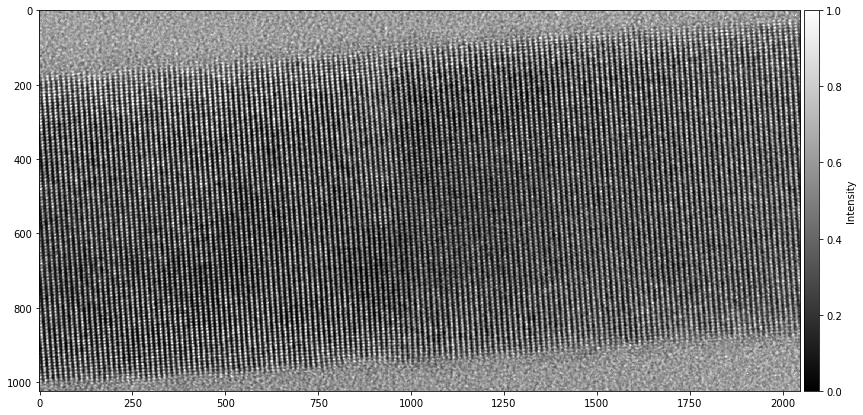

In [3]:
from psm.image import preprocess

image = np.array(pil_image).astype(float)

image = preprocess.normalize_range(image)

image = preprocess.remove_hot_pixels(image)

fig, ax = plt.subplots(figsize = (figsize, figsize//2))
im = ax.imshow(image.T, cmap='gray')
plotutils.add_colorbar(im, ax, size='2%', label='Intensity');

Noise degrades the accuracy of the positions of the identified structures and hence the final strain measurements. Frequently used spatial filters for denoising HR(S)TEM images include Wiener filter, Gaussian filter and Bragg filter.

[Scikit-image](http://scikit-image.org/) provides a large selection filters including a Wiener filter and a Gaussian filter under the [restoration](http://scikit-image.org/docs/dev/api/skimage.restoration.html) and [filters](http://scikit-image.org/docs/dev/api/skimage.filters.html) modules respectively.

However, here we will use the Bragg filter provided in this package. See Bragg filter tutorial for more information.

In [4]:
from psm.image import BraggFilter

bragg = BraggFilter(image)

In [5]:
bragg.register_diffraction_peaks(alpha=.1, min_sigma=5, max_sigma=15, progress_bar=True)

 [||||||||||||||||||||] 10/10 


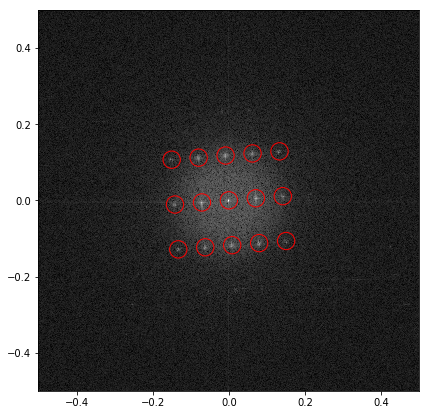

In [6]:
bragg.autoset_mask_centers(max_radius=.2)

fig,ax=plt.subplots(1,1,figsize=(figsize/2,figsize/2))
bragg.show_mask_centers(ax=ax, scale=.1, s=300);

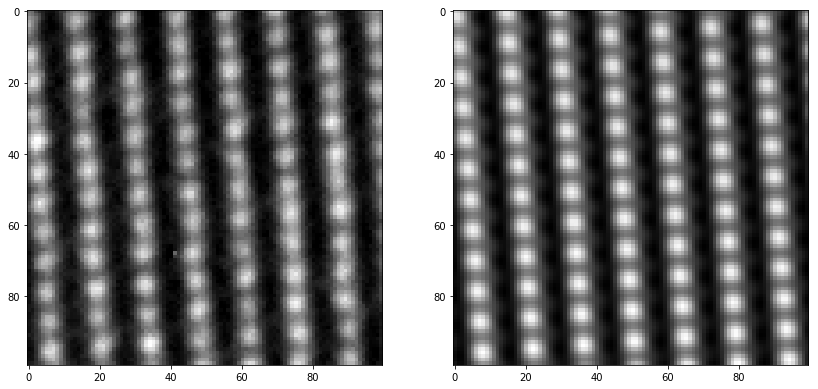

In [7]:
from psm.image.bragg import butterworth_mask

mask = butterworth_mask(5, ratio=2, order=4)
filtered = bragg.apply_filter(mask = mask)

fig, axes = plt.subplots(1,2,figsize=(figsize,figsize/2))
axes[0].imshow(image[600:700,600:700].T, cmap='gray')
axes[1].imshow(filtered[600:700,600:700].T, cmap='gray');

## Peak detection
Once we have a filtered image, the next step is to locate the structures in the image. In the simple case, each structure corresponds to a high-intensity peak. In cases where each structure does not correspond a single peak, it may be possible to use template matching (see tutorial).

The function `find_local_peaks` may be used to automatically identify the pixel positions of local intensity maxima in the image. A simple graphical user interface for manually adding missing or removing erronous peaks is provided through the `PointsEditor` object.

In [8]:
from psm.image.peaks import find_local_peaks

unrefined_peaks = find_local_peaks(filtered, min_distance=12, local_threshold=.4, exclude_border=10)

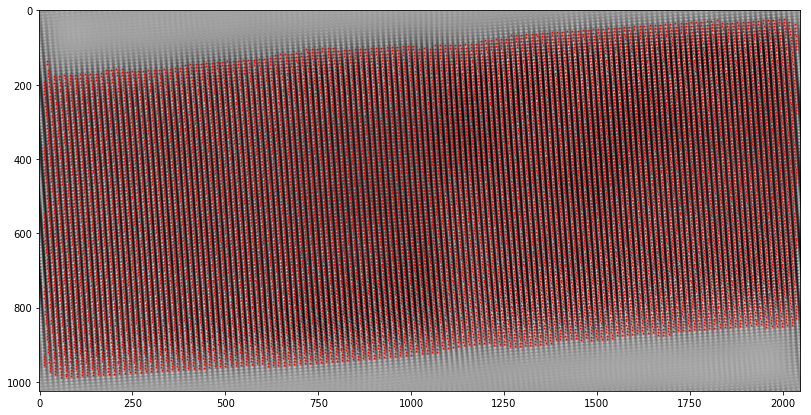

In [9]:
fig, ax = plt.subplots(figsize=(figsize, figsize/2))
ax.imshow(filtered.T, cmap='gray')
ax.scatter(unrefined_peaks[:,0], unrefined_peaks[:,1], s=1, c='r');

## Peak refinement
There are two unambiguous ways of measuring the position of an atomic column: From the position of the intensity extrema or from the center of mass, both methods are implemented with the functions `peaks.refine_peaks` and `peaks.refine_com`, respectively.

Determining the intensity extrema with sub-pixel accuracy is done by fitting a model function, to a region around the detected extrema. This package includes three choices of models: polynomial, circular Gaussian and elliptical Gaussian, given by respectively:

`Polynomial2D()`: 
$$ z(x,y) = z_0 + x + y + x^2 + xy + y^2 \quad , $$

`Gaussian2D()`:
$$ z(x,y) = z_0 + A \exp \left[-\left(\frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2}\right)\right] \quad \mathrm{and} $$

`Gaussian2D(elliptical=True)`:
$$ z(x,y) = z_0 + A \exp\left[- \left(a(x - x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right)\right] $$
where
$$ a = \frac{\cos^2\theta}{2\sigma_x^2} + \frac{\sin^2\theta}{2\sigma_y^2} \quad , \quad b=-\frac{\sin 2\theta}{4\sigma_x^2} + \frac{\sin 2\theta}{4\sigma_y^2} \quad \mathrm{and} \quad c = \frac{\sin^2\theta }{2\sigma_x^2} + \frac{\cos^2\theta}{2\sigma_y^2}. $$

In [10]:
from psm.image import refine_peaks, Polynomial2D

model = Polynomial2D()
peaks = refine_peaks(filtered, unrefined_peaks, model=model, extent=5, progress_bar=True)

 [||||||||||||||||||||] 14154/14154 fits


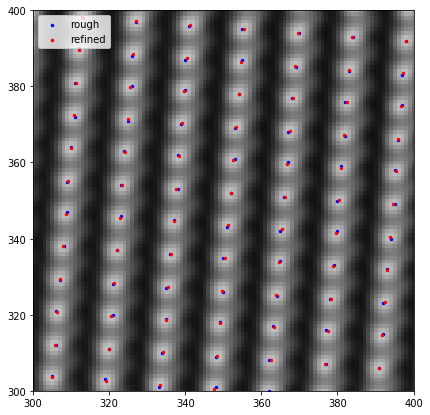

In [11]:
fig, ax = plt.subplots(figsize=(figsize/2,figsize/2))
ax.scatter(unrefined_peaks[:,0], unrefined_peaks[:,1], c='b', s=6, label='rough')
ax.scatter(peaks[:,0], peaks[:,1], c='r', s=6, label='refined')
ax.imshow(filtered.T, cmap='gray')
ax.set_xlim([300,400])
ax.set_ylim([300,400])

ax.legend();

## Strain analysis
For a detailed description wait for our forthcoming paper.

Given a set of points, representing the measured positions of structures, the process of calculating strain proceeds through the five steps below.

1. __Geometric graph:__ A [geometric graph](https://en.wikipedia.org/wiki/Geometric_graph_theory) of the points is constructed. This graph is used as the basis for quickly finding structure in the points.

2. __Template definition:__ Define expected (or ideal) local lattice piece(s).

3. __Segmentation:__ Segment the measured points into smaller pieces.

4. __Point set registration:__ For each segment, find the similarity to each template.

5. __Strain calculation:__ For each segment, the affine transformation from the most similar template to the segment is calculated. The deformation and rotation can be obtained via a decomposition of the affine matrix.

### 1. Geometric graph
To find robust segments and to find the point-to-point correpondences between the templates and the segments, a geometric graph of the points is defined. Typically a good choice is the [relative neighbourhood graph](https://en.wikipedia.org/wiki/Relative_neighborhood_graph), here we will use a good approximation, namely the [Urquhart graph](https://en.wikipedia.org/wiki/Urquhart_graph). The only restriction on the geometric graph is that it should be a [planar straight-line graph](https://en.wikipedia.org/wiki/Planar_straight-line_graph).


In [12]:
from psm.graph import urquhart

adjacency = urquhart(peaks)

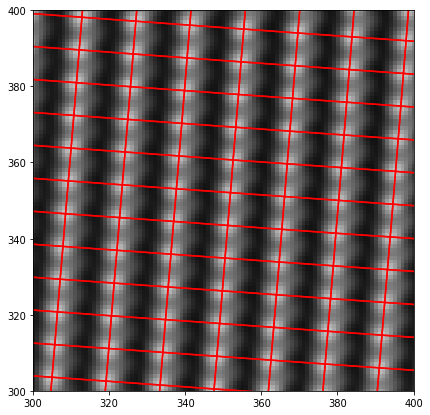

In [13]:
from psm.graph import subgraph

to_plot = (peaks[:,0] > 250)&(peaks[:,0] < 450)&(peaks[:,1] > 250)&(peaks[:,1] < 450)

fig, ax = plt.subplots(figsize=(figsize/2,figsize/2))
ax.imshow(filtered.T, cmap='gray')
plotutils.graph_embedding(peaks[to_plot], subgraph(adjacency, to_plot), ax=ax, color='r')

ax.set_xlim([300,400])
ax.set_ylim([300,400]);

### 2. Template definition
The strain is calculated with respect to an ideal reference lattice. This package implements two different approaches for defining the template:
1. Manual definition given knowledge of the expected lattice vectors and basis.
2. Using [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) and unsupervised machine learning to extract templates from averaged groups of segments (see [example notebook](poly_graphene_unsupervised.ipynb)).

In this tutorial we will use the former.

Since the matching algorithm is scale- and rotation invariant, the template can be defined without worrying about pixel size or lattice direction. Nonetheless, we still need to define the aspect ratio of the rectangles composing the lattice. We can obtain this from the theoretical wurtzite lattice, alternatively we can use the reciprocal lattice vectors found by the `BraggFilter` object.

In [14]:
norms = np.linalg.norm(bragg.reciprocal_lattice, axis=1)
aspect = norms[0] / norms[1]

print('lattice aspect ratio:', aspect)

lattice aspect ratio: 1.6624795305269404


A larger template gives a more noise resistant strain measure, while a smaller template provides a higher spatial resolution. We choose to use templates consisting of a point in the lattice and its 8 nearest neighbors. Since the symmetry order of the points  , $2$, is lower than the number of points adjacent to the root, $4$, we need $4 / 2 = 2$ templates to ensure positive matches.

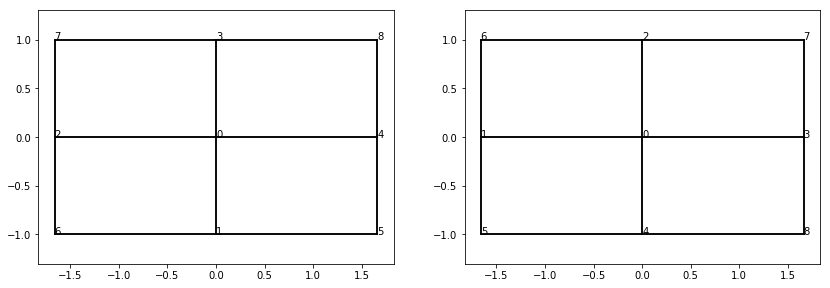

In [15]:
from psm.build import lattice_traversal

a = [0, 1]
b = [aspect, 0]

templates = lattice_traversal(a, b, radius=1.95, graph_func=urquhart)

fig,axes=plt.subplots(1,2,figsize=(figsize,figsize/3))
axes = plotutils.show_structures(templates, axes=axes, show_order=True)
for ax in axes:
    ax.axis('equal')

### 3. Segmentation
In this program a segment is an ordered subset of a larger set of points.

The `Structures` object consists of an array of points, a list of segments of these points given as a list of indices and a geometric graph of the points given as an adjacency list

In [16]:
from psm.structures import traverse_from_all

structures = traverse_from_all(peaks, adjacency,  max_depth=3, max_per_point=1, progress_bar=True)

 [||||||||||||||||||||] 14154/14154 traversals


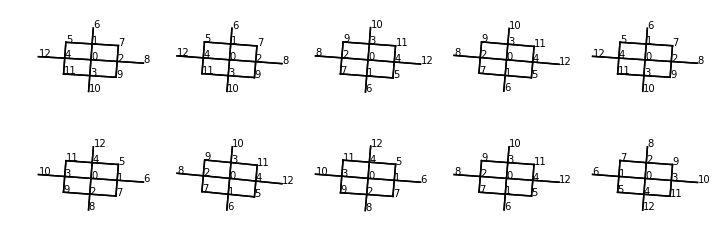

In [17]:
fig,axes = plt.subplots(2,5,figsize=(12,4))
plotutils.show_structures(structures.sample(10), axes=axes.ravel(), show_order=True)
for ax in axes.ravel():
    ax.axis('equal')
    ax.axis('off')

### 4. Point set registration
#### Similarity

 This is measured using the [Root-Mean-Squared Deviation](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions) (RMSD).
Each segment is compared to each templates 

are compared using the RMSD and the template with lowest RMSD is attached segment.

Denoting the set of $N$ points in a segment $P=\{p_i\}$ and a given template, $Q=\{q_i\}$, with the same number of points. The RMSD is calculated as

$$ RMSD(P,Q) = \sqrt{\frac{1}{N} \sum_{i=1}^N \|(p_i - p_0) - (q_i - q_0)\|_2^2} \quad ,$$

where $p_0$ and $q_0$ is the segment and template origin, respectively. The RMSD is made invariant to scale (absolute and relative) and rotation, by finding the optimal rotation and scale, between the two sets of points.

$$    \mathrm{RMSD}(\mathbf{P},\mathbf{Q}) = \min_{\mathbf{U},s} \sqrt{ \frac{1}{N} \sum_{i=1}^N \left\lVert \frac{[\mathbf{p}_i-\bar{\mathbf{p}}]}{S(\mathbf{P})} - s(\mathbf{U}[\mathbf{q}_i-\bar{\mathbf{q}}]^T)^T\right\rVert_2^2} \quad , $$

where $s$ is a number (the scale factor), $U$ is an orthogonal matrix (the rotation matrix) and 
$$
S(Q) = \sqrt{\frac{1}{N} \sum_{i=1}^N q_i^2}.
$$

#### Permutational alignment
We use [point set registration](https://en.wikipedia.org/wiki/Point_set_registration) to match each segment with a template (and to calculate the strain). This requires that we find the correspondence between the points in a segment and the points in the templates.

There are $N!$ possible orderings of a set of $N$ points, hence a brute force approach is infeasible. This package provides two algorithms for aligning sets of points.

1. __Clockwise traversal:__ The point segments are aligned using [graph canonization](https://en.wikipedia.org/wiki/Graph_canonization) for plane straight-line graphs.

2. __Branch and bound:__ The RMSD optimized in rotation space. This is slower than the graph based methods, but does not require a graph.


In [18]:
from psm.register import MatchGraph
from tqdm import tqdm

In [19]:
rmsd_calc = MatchGraph(transform='similarity', pivot='front', subgraph_isomorphism=True)
rmsd = rmsd_calc.register(templates, structures)

 [||||||||||||||||||||] 28310/28310 registrations


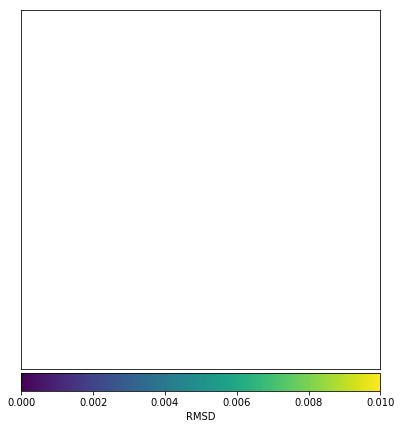

In [20]:
_,best_rmsd = rmsd_calc.best_matches(structures)

fig,ax = plt.subplots(1,1,figsize=(figsize,figsize/2))
p = plt.scatter(structures.fronts[:,0], structures.fronts[:,1],
            c=best_rmsd, cmap='viridis', vmin=0, vmax=.01, s=20)

plotutils.add_colorbar(p, ax, 'bottom', label='RMSD')

ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([]);

### 5. Strain calculation
The orientation and deformation gradient matrices are obtained via a left-sided polar decomposition of the deformation gradient

$$ PU = A \quad , $$

where U is an orthogonal right-handed matrix (the rotation matrix), and P is a symmetric matrix (the deformation gradient). The components of the strain tensor is are then calculated as

$$ \begin{bmatrix}
\epsilon_{xx} & \epsilon_{xy} \\
\epsilon_{yx} & \epsilon_{yy} \\
\end{bmatrix} = 
\begin{bmatrix}
P_{1,1} - 1 & P_{1,2} \\
P_{2,1} & P_{2,2} -1 \\
\end{bmatrix} \quad ,$$ 

and the rotation is given by

$$ \theta = \operatorname{atan2}(U_{1,0},U_{0,0}) \quad . $$

The rotation is only defined modulo $2\pi/N$ where $N$ is rotational symmetry order of the template.

In [21]:
strain, rotation = rmsd_calc.calc_strain(structures)

We did not define the scale of the template, hence it is necessary to rescale the strain tensor. This is done by requiring that the median planar strain over a region is zero

$$\bar{\epsilon_p} = 0$$

Thus the rescaled strains are given by

$$ \epsilon_{xx} = (\epsilon_{xx} - 1)/ \bar{\epsilon_p} + 1 \quad \mathrm{and} \quad \epsilon_{yy} = (\epsilon_{yy} - 1)/ \bar{\epsilon_p} + 1 \quad .$$ 

In [22]:
from psm.geometry import transform

In [23]:
median_rotation = np.nanmedian(rotation % np.pi)

transformed_strain = transform.zero_median(strain)

transformed_strain = transform.rotate_strain(transformed_strain, median_rotation)

planar = transform.planar_strain(transformed_strain)

transformed_rotation = (rotation % np.pi - median_rotation)

rotated = transform.rotate_points(structures.fronts, -median_rotation)

C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in remainder
  """Entry point for launching an IPython kernel.
C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


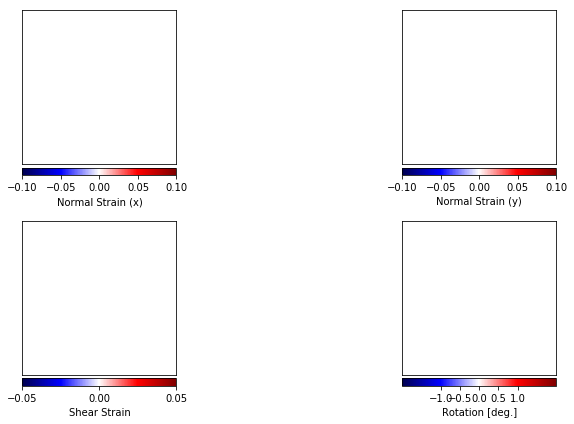

In [24]:
fig,axes = plt.subplots(2,2,figsize=(13,6))
axes = axes.ravel()

p = axes[0].scatter(rotated[:,0], rotated[:,1],
                c=transformed_strain[:,0,0], cmap='seismic', vmin=-.1, vmax=.1, s=10)
plotutils.add_colorbar(p, axes[0], 'bottom', label='Normal Strain (x)', ticks=np.linspace(-0.1,.1,5))

p = axes[1].scatter(rotated[:,0], rotated[:,1],
                c=transformed_strain[:,1,1], cmap='seismic', vmin=-.1, vmax=.1, s=10)
plotutils.add_colorbar(p, axes[1], 'bottom', label='Normal Strain (y)', ticks=np.linspace(-0.1,.1,5))

p = axes[2].scatter(rotated[:,0], rotated[:,1],
                c=transformed_strain[:,0,1], cmap='seismic', vmin=-.05, vmax=.05, s=10)
plotutils.add_colorbar(p, axes[2], 'bottom', label='Shear Strain', ticks=np.linspace(-0.1,.1,5))

p = axes[3].scatter(rotated[:,0], rotated[:,1],
                c=transformed_rotation / np.pi * 180, cmap='seismic', vmin=-2, vmax=2, s=10)
plotutils.add_colorbar(p, axes[3], 'bottom', label='Rotation [deg.]', ticks=np.linspace(-1,1,5))

for ax in axes:
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Interpolation and strain profiles
For some purposes, such as getting the strain profile along a line, it is practical to represent the strain on a regular grid. The `griddata` function from Scipy can be used to interpolate the strain from the irregular segment positions to a regular grid.

In [25]:
from scipy.interpolate import griddata

n_x = 600
n_y = 400
xlim = [rotated[:,0].min(), rotated[:,0].max()]
ylim = [rotated[:,1].min(), rotated[:,1].max()]

x = np.linspace(xlim[0], xlim[1], n_x)
y = np.linspace(ylim[0], ylim[1], n_y)
x,y = np.meshgrid(x,y,indexing='xy')

normal_x = griddata(rotated, transformed_strain[:,0,0], (x,y), method='linear')
normal_y = griddata(rotated, transformed_strain[:,1,1], (x,y), method='linear')

C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: Points cannot contain NaN

In [ ]:
region = [100, 500, 150, 250]

aspect = n_x/n_y * (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

fig,axes=plt.subplots(1,2,figsize=(2*figsize/3,figsize/4))

p = axes[0].imshow(normal_x, cmap = 'seismic', interpolation='nearest', aspect=aspect, vmin=-.1, vmax=.1)
plotutils.add_colorbar(p, axes[0], 'bottom', label='Normal Strain (x)', ticks=np.linspace(-0.1,.1,5))

im = axes[1].imshow(normal_y, cmap = 'seismic', interpolation='nearest', aspect=aspect, vmin=-.1, vmax=.1)
plotutils.add_colorbar(p, axes[1], 'bottom', label='Normal Strain (y)', ticks=np.linspace(-0.1,.1,5))

for ax in axes:
    ax.add_patch(matplotlib.patches.Rectangle((region[0], region[2]),
                    region[1]-region[0], region[3]-region[2], fill=False))
    
plt.tight_layout()

In [ ]:
normal_x_mean = np.nanmean(normal_x[region[2]:region[3],region[0]:region[1]], axis=0)
normal_y_mean = np.nanmean(normal_y[region[2]:region[3],region[0]:region[1]], axis=0)

fig,axes=plt.subplots(1,2,figsize=(2*figsize/3,figsize/4))

axes[0].plot(normal_x_mean)
axes[0].set_xlabel('x [interp. coord.]')
axes[0].set_ylabel('$\epsilon_{xx}$')

axes[1].plot(normal_y_mean)
axes[1].set_xlabel('x [interp. coord.]')
axes[1].set_ylabel('$\epsilon_{yy}$')

plt.tight_layout()